In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c gan-getting-started
import zipfile
myzip = zipfile.ZipFile('gan-getting-started.zip')
zip.extractall()

mkdir: cannot create directory ‘/root/.kaggle’: File exists
gan-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#import zipfile
#zip = zipfile.ZipFile('gan-getting-started.zip')
#zip.extractall()

# I’m Something of a Painter Myself- Kaggle Mini-Project
+ Project Description:
  + This project is based on the Kaggle competition titled "I'm Something of a Painter Myself" and the data can be found [here](https://www.kaggle.com/competitions/gan-getting-started/data). This project uses a generative adversarial network (GAN) to generate Monet images from photos.
+ Data:
  + There are 4 directories: monet_jpg, monet_tfrec, photo_jpg, and photo_tfrec. Images are 256x256.
    + monet_jpg- painting images used to train
      + 300 jpg images
    + monet_tfrec- painting images used to train
      + 300 TFRecord images
    + photo_jpg- photo images to change to Monet style
      + 7028 jpg images
    + photo_tfrec- photo images to change to Monet style
      + 7028 TFRecord images


## Exploratory Data Analysis (EDA)



In [ ]:
# Import Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image

* Count images in each directory:

In [ ]:
#monet_dir = '/content/monet_jpg'
#monet_tfdir = '/content/monet_tfrec'
#photo_dir =  '/content/photo_jpg'
#photo_tfdir =  '/content/photo_tfrec'
monet_dir = '/kaggle/input/gan-getting-started/monet_jpg/'
monet_tfdir = '/kaggle/input/gan-getting-started/monet_tfrec/'
photo_dir =  '/kaggle/input/gan-getting-started/photo_jpg/'
photo_tfdir =  '/kaggle/input/gan-getting-started/photo_tfrec/'

monet_images = [f for f in listdir(monet_dir)]
monet_imagestf = [f for f in listdir(monet_tfdir)]
photo_images = [f for f in listdir(photo_dir)]
photo_imagestf = [f for f in listdir(photo_tfdir)]
print('Monet Paintings-', (len(monet_images)))
print('Monet Paintings tfrec-', (len(monet_imagestf)))
print('Photos-', (len(photo_images)))
print('Photos tfrec-', (len(photo_imagestf)))

Monet Paintings- 300
Monet Paintings tfrec- 5
Photos- 7038
Photos tfrec- 20




*   **Visualiations- 3 Monet Paintings:**

Below is an example of 3 Monet images


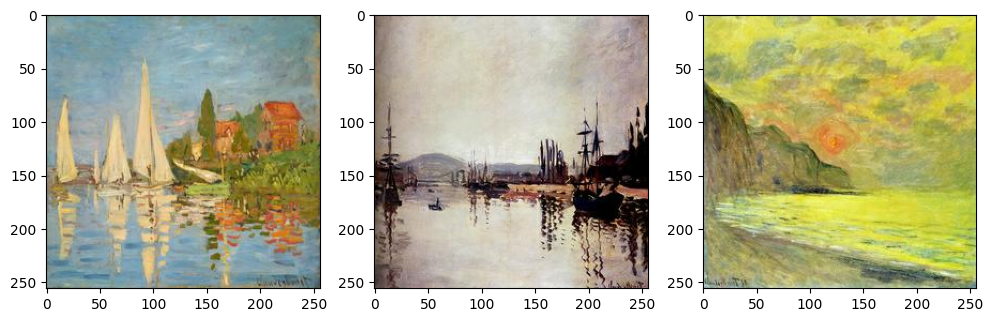

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12,12))
for i, axis in enumerate(ax):
    image = Image.open(monet_dir + '/' + monet_images[i])
    ax[i].imshow(image)
    image.format
    image.size
plt.show()



*   **Visualizations- 3 Photos:**

Below is an example of 3 photos





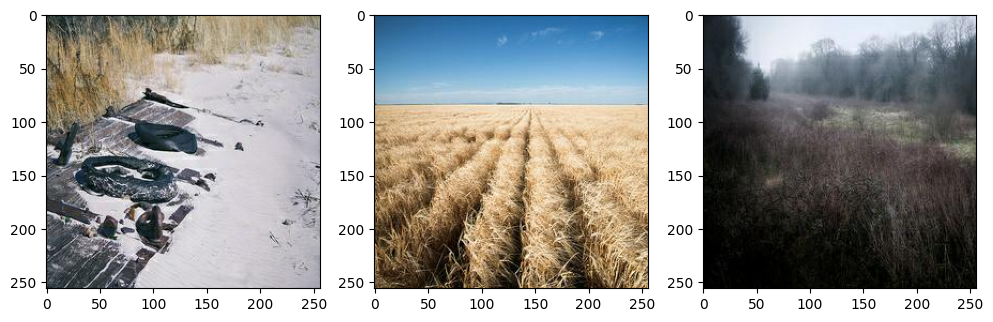

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12,12))
for i, axis in enumerate(ax):
    image = Image.open(photo_dir + '/' + photo_images[i])
    ax[i].imshow(image)
plt.show()

## Build Model




+ The following functions will help to normalize the images

In [ ]:
# Decode JPG image to RGB
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*[256, 256], 3])
    return image

# Parse photo to decode
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

# Upload dataset
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

monet_ds = load_dataset([os.path.join(monet_tfdir, f) for f in monet_imagestf], labeled=True).batch(1)
photo_ds = load_dataset([os.path.join(photo_tfdir, f) for f in photo_imagestf], labeled=True).batch(1)

*   **Generator Model**

The generator creates an image which will be compared to the actual image. The down function convers photos into inputs, and up converts outputs into images.

In [ ]:
def down(filters, size, apply_instancenorm=True):
  initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
  gamma = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  result = keras.Sequential()
  result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
  if apply_instancenorm:
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma))
  result.add(layers.LeakyReLU())
  return result

def up(filters, sizes, apply_dropout=False):
  initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
  gamma = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  result = keras.Sequential()
  result.add(layers.Conv2DTranspose(filters, sizes, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
  result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma))
  if apply_dropout:
    result.add(layers.Dropout(0.5))
  result.add(layers.ReLU())
  return result

def generator():
  inputs = layers.Input(shape=[256,256,3])
  down_stack = [
    down(64, 4, apply_instancenorm=False),
    down(128, 4),
    down(256, 4),
    down(512, 4),
    down(512, 4),
    down(512, 4),
    down(512, 4),
    down(512, 4)]

  up_stack = [
    up(512, 4, apply_dropout=True),
    up(512, 4, apply_dropout=True),
    up(512, 4, apply_dropout=True),
    up(512, 4),
    up(256, 4),
    up(128, 4),
    up(64, 4)]

  initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
  last = layers.Conv2DTranspose(filters=3,
                                kernel_size=4,
                                strides=2,
                                padding='same',
                                kernel_initializer=initializer,
                                activation='tanh')
  x = inputs

  skips = []
  for d in down_stack:
    x= d(x)
    skips.append(x)
  skips = reversed(skips[:-1])

  for u, skip in zip(up_stack, skips):
    x = u(x)
    x = layers.Concatenate()([x, skip])

  return keras.Model(inputs=inputs, outputs=last(x))

In [ ]:
gen = generator()
gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_41 (Sequential)  (None, 128, 128, 64)         3072      ['input_7[0][0]']             
                                                                                                  
 sequential_42 (Sequential)  (None, 64, 64, 128)          131328    ['sequential_41[0][0]']       
                                                                                                  
 sequential_43 (Sequential)  (None, 32, 32, 256)          524800    ['sequential_42[0][0]']       
                                                                                              

+  **Discriminator Model**

The discriminator compares photos to generated images to train the model.

In [ ]:
def discriminator():
  initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
  gamma = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  inputs = layers.Input(shape=[256,256,3], name='input_image')
  x = inputs
  down1 = down(64, 4, False)(x)
  down2 = down(128, 4)(down1)
  down3 = down(256, 4)(down2)
  pad1 = layers.ZeroPadding2D()(down3)
  conv = layers.Conv2D(512, 4, strides=1,
                       kernel_initializer=initializer,
                       use_bias=False)(pad1)
  instnorm = tfa.layers.InstanceNormalization(gamma_initializer=gamma)(conv)
  leaky_relu = layers.LeakyReLU()(instnorm)
  pad2 = layers.ZeroPadding2D()(leaky_relu)
  last = layers.Conv2D(1, 4, strides=1,
                       kernel_initializer=initializer)(pad2)
  return tf.keras.Model(inputs, last)

In [ ]:
disc = discriminator()
disc.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 sequential_62 (Sequential)  (None, 128, 128, 64)      3072      
                                                                 
 sequential_63 (Sequential)  (None, 64, 64, 128)       131328    
                                                                 
 sequential_64 (Sequential)  (None, 32, 32, 256)       524800    
                                                                 
 zero_padding2d_2 (ZeroPadd  (None, 34, 34, 256)       0         
 ing2D)                                                          
                                                                 
 conv2d_45 (Conv2D)          (None, 31, 31, 512)       2097152   
                                                           

In [ ]:
# Generates monets and photos
monet_generator = generator()
photo_generator = generator()
# Discriminates monets and photos
monet_discriminator = discriminator()
photo_discriminator = discriminator()

+ Photo vs Monet at Epoch = 1

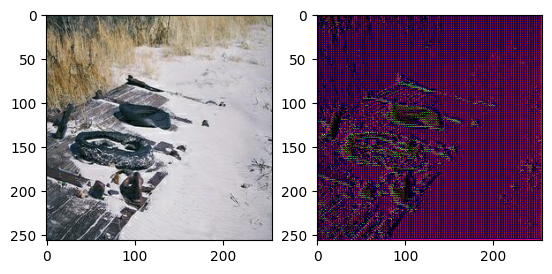

In [ ]:
import tensorflow as tf
from PIL import Image

pic = next(iter(photo_images))
plt.subplot(121)
plt.imshow(Image.open(photo_dir + '/' + pic))
image_path = photo_dir + '/' + pic
image = Image.open(image_path)
image = np.array(image)
image = tf.convert_to_tensor(image)
monet = monet_generator(tf.expand_dims(image, axis=0))
plt.subplot(122)
plt.imshow(monet[0, :, :, :])

In [ ]:
monet_generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_63 (Sequential)  (None, 128, 128, 64)         3072      ['input_6[0][0]']             
                                                                                                  
 sequential_64 (Sequential)  (None, 64, 64, 128)          131584    ['sequential_63[0][0]']       
                                                                                                  
 sequential_65 (Sequential)  (None, 32, 32, 256)          525312    ['sequential_64[0][0]']       
                                                                                            

* CycleGAN Model adapted from Kaggle tutorial

In [ ]:
class CycleGan(keras.Model):
    def __init__(self,monet_generator,photo_generator,monet_discriminator,photo_discriminator,lambda_cycle=10,):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(self,m_gen_optimizer,p_gen_optimizer,m_disc_optimizer,p_disc_optimizer,gen_loss_fn,disc_loss_fn,cycle_loss_fn,identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)


            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

+ Loss Functions to use in the compile method:

In [ ]:
with tf.distribute.MirroredStrategy().scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                       reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real),
                                                                                                 real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                            reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated),
                                                                                                      generated)
        total_disc_loss = real_loss + generated_loss
        return tf.reduce_mean(total_disc_loss) * 0.5

with tf.distribute.MirroredStrategy().scope():
    def generator_loss(generated):
      return tf.reduce_mean(tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
                         (tf.ones_like(generated), generated))

with tf.distribute.MirroredStrategy().scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        real_image = tf.cast(real_image, tf.float32)
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

with tf.distribute.MirroredStrategy().scope():
    def identity_loss(real_image, same_image, LAMBDA):
        real_image = tf.cast(real_image, tf.float32)
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [ ]:
with tf.distribute.MirroredStrategy().scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
with tf.distribute.get_strategy().scope():
    cycle_gan_model = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)
    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss)

## Results

I first fit the model with only 5 epochs:

In [ ]:
history = cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=5)

Epoch 1/5
300/300 [==============================] - 131s 436ms/step - monet_gen_loss: 3.6455 - photo_gen_loss: 3.8178 - monet_disc_loss: 0.6751 - photo_disc_loss: 0.6052
Epoch 2/5
300/300 [==============================] - 129s 428ms/step - monet_gen_loss: 3.5996 - photo_gen_loss: 3.9122 - monet_disc_loss: 0.6602 - photo_disc_loss: 0.5714
Epoch 3/5
300/300 [==============================] - 129s 428ms/step - monet_gen_loss: 3.5225 - photo_gen_loss: 3.9416 - monet_disc_loss: 0.6480 - photo_disc_loss: 0.5302
Epoch 4/5
300/300 [==============================] - 128s 428ms/step - monet_gen_loss: 3.3921 - photo_gen_loss: 3.6615 - monet_disc_loss: 0.6368 - photo_disc_loss: 0.6039
Epoch 5/5
300/300 [==============================] - 128s 426ms/step - monet_gen_loss: 3.2716 - photo_gen_loss: 3.4489 - monet_disc_loss: 0.6254 - photo_disc_loss: 0.6142


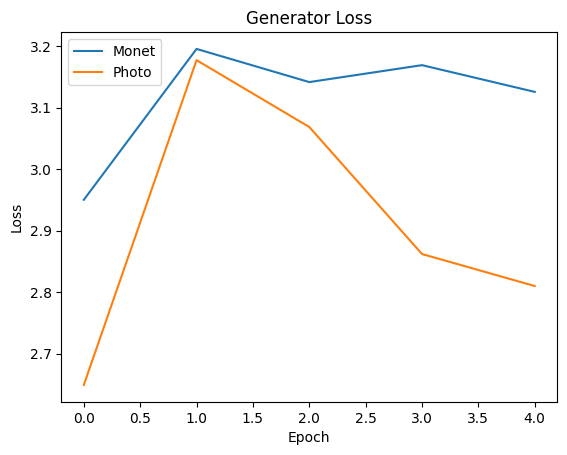

In [ ]:
plt.plot(history.history['monet_gen_loss'])
plt.plot(history.history['photo_gen_loss'])
plt.title('Generator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Monet', 'Photo'], loc='upper left')
plt.show()

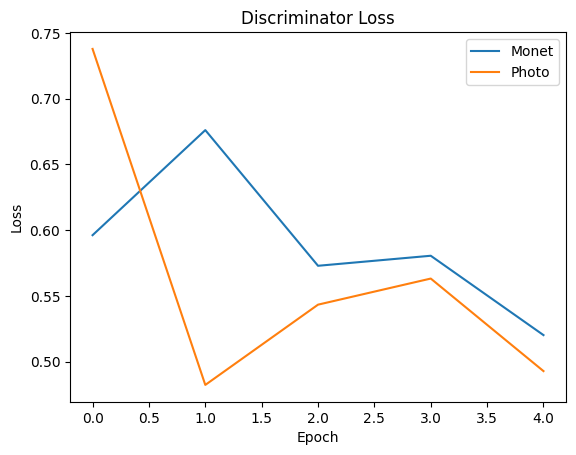

In [ ]:
plt.plot(history.history['monet_disc_loss'])
plt.plot(history.history['photo_disc_loss'])
plt.title('Discriminator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Monet', 'Photo'], loc='upper right')
plt.show()

After working out some connection issues with Colab, I fit again using 30 epochs. This had a better result until between epochs 15-20.

In [ ]:
history2 = cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=30)

Epoch 1/30
300/300 [==============================] - 129s 429ms/step - monet_gen_loss: 3.2162 - photo_gen_loss: 3.3510 - monet_disc_loss: 0.6164 - photo_disc_loss: 0.6049
Epoch 2/30
300/300 [==============================] - 128s 426ms/step - monet_gen_loss: 3.1900 - photo_gen_loss: 3.2997 - monet_disc_loss: 0.6112 - photo_disc_loss: 0.6048
Epoch 3/30
300/300 [==============================] - 129s 431ms/step - monet_gen_loss: 3.1695 - photo_gen_loss: 3.2589 - monet_disc_loss: 0.6068 - photo_disc_loss: 0.6053
Epoch 4/30
300/300 [==============================] - 128s 427ms/step - monet_gen_loss: 3.1482 - photo_gen_loss: 3.2114 - monet_disc_loss: 0.6021 - photo_disc_loss: 0.6118
Epoch 5/30
300/300 [==============================] - 128s 426ms/step - monet_gen_loss: 3.1094 - photo_gen_loss: 3.1474 - monet_disc_loss: 0.5984 - photo_disc_loss: 0.6095
Epoch 6/30
300/300 [==============================] - 128s 426ms/step - monet_gen_loss: 3.0784 - photo_gen_loss: 3.1158 - monet_disc_loss: 0

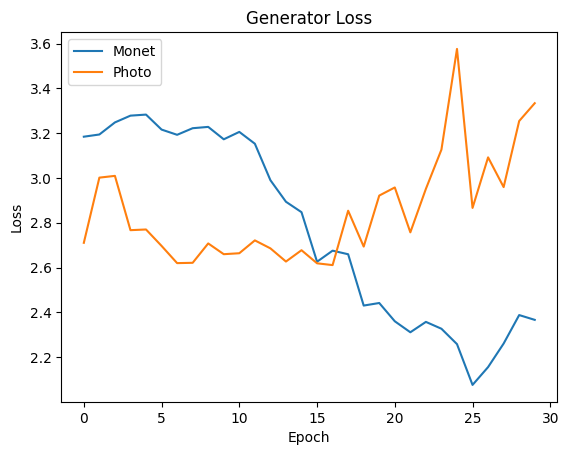

In [ ]:
plt.plot(history2.history['monet_gen_loss'])
plt.plot(history2.history['photo_gen_loss'])
plt.title('Generator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Monet', 'Photo'], loc='upper left')
plt.show()

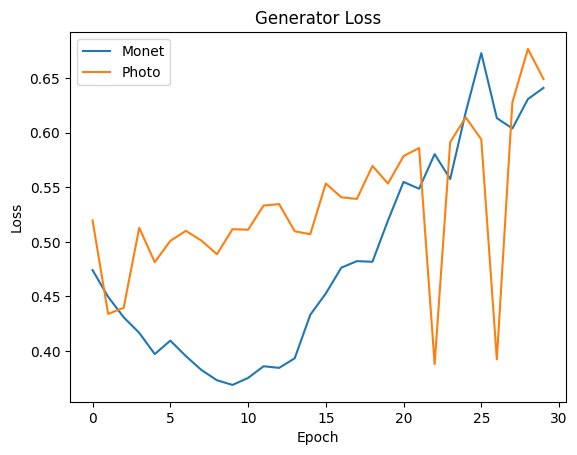

In [ ]:
plt.plot(history2.history['monet_disc_loss'])
plt.plot(history2.history['photo_disc_loss'])
plt.title('Generator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Monet', 'Photo'], loc='upper left')
plt.show()

+ Below are some sample resuls of a photo and resulting Monet generated images

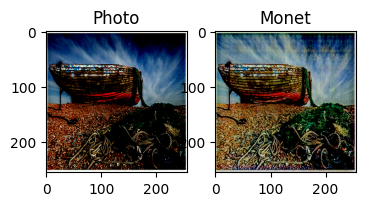

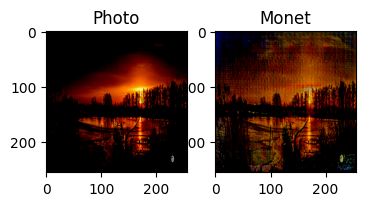

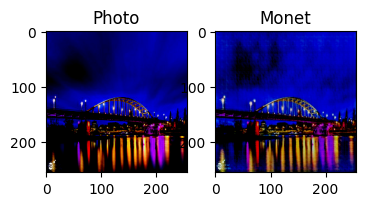

In [ ]:
import warnings
warnings.filterwarnings('ignore')
photos = iter(photo_ds)
for i in range(3):
    image = next(photos)
    monet = monet_generator(image)
    f = plt.figure(figsize=(6,6))
    plt.subplot(121)
    plt.title('Photo')
    plt.imshow(image[0])
    plt.subplot(122)
    plt.title('Monet')
    plt.imshow(monet[0])
    plt.show()

# Conclusion

Looking at the resulting Monet images, I don't think the results were the greatest. Due to issues with Colab, I wasn't able to compare images between 5 and 30 epochs, but suspect that somehwere around 20 may have generated the best results.


Referenced from Kaggle Tutorial [here.](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial)